In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_homophily_check(data, save_path=None, plot_title=''):
    """
    This function takes a pandas DataFrame and performs the homophily check analysis,
    plotting the average selection ratio against the number of shared features for each condition.
    Optionally, it saves the plot to the specified save_path.
    """
    # Step 1: Calculate counts of each shared feature level for each subject and retain condition


    # DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
    feature_counts = data.groupby('subject').apply(
        lambda x: pd.Series({
            'condition': x['condition'].iloc[0],
            'count_0': (x['shared_features'] == 0).sum(),
            'count_1': (x['shared_features'] == 1).sum(),
            'count_2': (x['shared_features'] == 2).sum(),
            'count_3': (x['shared_features'] == 3).sum(),
        })
    ).reset_index()

    # Step 2: Join these counts back to the main data frame based on the subject
    data = data.drop(columns=['condition'])
    data = data.merge(feature_counts, on='subject', how='left')

    # Step 3: Calculate expected proportions for each subject and shared feature level
    expected_proportions = data.groupby('subject').apply(
        lambda x: pd.Series({
            'condition': x['condition'].iloc[0],
            'expected_prop_0': (x['shared_features'] == 0).sum() / 9,
            'expected_prop_1': (x['shared_features'] == 1).sum() / 9,
            'expected_prop_2': (x['shared_features'] == 2).sum() / 9,
            'expected_prop_3': (x['shared_features'] == 3).sum() / 9,
        })
    ).reset_index()

    # Step 4: Calculate observed proportions for each subject and shared feature level
    observed_counts = data[data['chosen'] == 1].groupby(['subject', 'shared_features']).size().unstack(fill_value=0).reset_index()
    observed_counts.columns.name = None

    # Rename the columns to ensure they match expected names
    for i in range(4):
        col_name = f'observed_{i}'
        if i in observed_counts.columns:
            observed_counts.rename(columns={i: col_name}, inplace=True)
        else:
            observed_counts[col_name] = 0

        observed_counts[f'observed_prop_{i}'] = observed_counts[col_name] / 4

    # Keep only subject and observed_prop columns
    observed_proportions = observed_counts[['subject'] + [f'observed_prop_{i}' for i in range(4)]]

    # Step 5: Join expected and observed proportions, retaining condition without duplicates
    data_proportions = expected_proportions.merge(observed_proportions, on='subject', how='left')

    # Step 6: Calculate proportional ratios for each shared feature level
    for i in range(4):
        data_proportions[f'ratio_{i}'] = data_proportions[f'observed_prop_{i}'] / data_proportions[f'expected_prop_{i}']

    # Step 7: Reshape data to long format for easier plotting and comparison
    id_vars = ['subject', 'condition']
    value_vars = [f'ratio_{i}' for i in range(4)]
    data_long = pd.melt(
        data_proportions,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='shared_feature_level',
        value_name='selection_ratio'
    )

    # Extract shared_feature_level as numeric
    data_long['shared_feature_level'] = data_long['shared_feature_level'].str.extract('(\d+)').astype(int)

    # Step 8: Calculate average selection ratio by shared feature level and condition
    average_ratios = data_long.groupby(['condition', 'shared_feature_level'])['selection_ratio'].mean().reset_index(name='mean_ratio')

    # Check if average_ratios is empty
    if average_ratios.empty:
        print("No data to plot.")
        return

    # Step 9: Plotting:
    plt.figure()
    sns.lineplot(
        data=average_ratios,
        x='shared_feature_level',
        y='mean_ratio',
        hue='condition',
        marker='o'
    )
    plt.xlabel('Number of Shared Features')
    plt.ylabel('Average Selection Ratio')
    plt.title(plot_title)
    plt.legend(title='Condition')
    plt.tight_layout()
    # Display the plot if not saving
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()  # Close the figure to free memory

<>:77: SyntaxWarning: invalid escape sequence '\d'
<>:77: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:77: SyntaxWarning: invalid escape sequence '\d'
  data_long['shared_feature_level'] = data_long['shared_feature_level'].str.extract('(\d+)').astype(int)


In [2]:
# Set up paths to your datasets
dataset_paths = {
    'first_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/first_pass_data.csv',
    'second_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/second_pass_data.csv',
    'third_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/third_pass_data.csv',
    'fourth_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/fourth_pass_data.csv',
}

# Output directory for saving plots
output_dir = '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/figures/'
os.makedirs(output_dir, exist_ok=True)

# Loop through each dataset and generate plots
for dataset_name, dataset_path in dataset_paths.items():
    # Load the data
    data = pd.read_csv(dataset_path)
    
    # Ensure the necessary columns are present
    required_columns = ['subject', 'condition', 'task_type', 'ordering', 'shared_features', 'chosen']
    missing_columns = set(required_columns) - set(data.columns)
    if missing_columns:
        print(f"Dataset {dataset_name} is missing columns: {missing_columns}")
        continue

    # Define combinations to loop through
    combinations = []

    # 1) All orderings and all task types [1 plot per dataset]
    combinations.append({'name': 'overall', 'filters': {}})

    # Get unique levels for ordering and task_type
    ordering_levels = data['ordering'].unique()
    task_type_levels = data['task_type'].unique()

    # 2) Each ordering, across all task types
    if len(ordering_levels) > 1:
        for ordering in ordering_levels:
            combinations.append({
                'name': f'ordering_{ordering}',
                'filters': {'ordering': ordering}
            })
    else:
        # Ordering has only one level in first_pass_data
        print(f"Dataset {dataset_name} has only one ordering level.")

    # 3) Each task type, across all orderings
    for task_type in task_type_levels:
        combinations.append({
            'name': f'task_type_{task_type}',
            'filters': {'task_type': task_type}
        })

    # 4) Each task type and each ordering
    if len(ordering_levels) > 1:
        for task_type in task_type_levels:
            for ordering in ordering_levels:
                combinations.append({
                    'name': f'task_type_{task_type}_ordering_{ordering}',
                    'filters': {'task_type': task_type, 'ordering': ordering}
                })
    else:
        # Skip since only one ordering level
        print(f"Dataset {dataset_name} does not have multiple ordering levels for task_type and ordering combinations.")

    # Loop through combinations and generate plots
    for combo in combinations:
        plot_name = f"{dataset_name}_{combo['name']}"
        # Apply filters
        filtered_data = data
        for key, value in combo['filters'].items():
            filtered_data = filtered_data[filtered_data[key] == value]
        
        # Check if filtered_data is not empty
        if filtered_data.empty:
            print(f"No data for {plot_name}, skipping.")
            continue
        
        # Generate the plot
        save_path = os.path.join(output_dir, f"{plot_name}.png")
        plot_title = f"Homophily Check: {dataset_name} - {combo['name']}"
        print(f"Generating plot: {plot_name}")
        plot_homophily_check(filtered_data, save_path=save_path, plot_title=plot_title)

Dataset first_pass has only one ordering level.
Dataset first_pass does not have multiple ordering levels for task_type and ordering combinations.
Generating plot: first_pass_overall
Generating plot: first_pass_task_type_full_ranking
Generating plot: first_pass_task_type_choice_ranking


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: second_pass_overall
Generating plot: second_pass_ordering_0
Generating plot: second_pass_ordering_1


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: second_pass_task_type_full_ranking
Generating plot: second_pass_task_type_choice_ranking


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: second_pass_task_type_full_ranking_ordering_0
Generating plot: second_pass_task_type_full_ranking_ordering_1
Generating plot: second_pass_task_type_choice_ranking_ordering_0


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: second_pass_task_type_choice_ranking_ordering_1
Generating plot: third_pass_overall
Generating plot: third_pass_ordering_1


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: third_pass_ordering_0
Generating plot: third_pass_task_type_full_ranking
Generating plot: third_pass_task_type_choice_ranking


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: third_pass_task_type_full_ranking_ordering_1
Generating plot: third_pass_task_type_full_ranking_ordering_0
Generating plot: third_pass_task_type_choice_ranking_ordering_1


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: third_pass_task_type_choice_ranking_ordering_0
Generating plot: fourth_pass_overall


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: fourth_pass_ordering_1
Generating plot: fourth_pass_ordering_0
Generating plot: fourth_pass_task_type_full_ranking


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: fourth_pass_task_type_choice_ranking
Generating plot: fourth_pass_task_type_full_ranking_ordering_1


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: fourth_pass_task_type_full_ranking_ordering_0
Generating plot: fourth_pass_task_type_choice_ranking_ordering_1
Generating plot: fourth_pass_task_type_choice_ranking_ordering_0


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

In [22]:
# Set up paths to your datasets
dataset_paths = {
    'first_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/first_pass_data.csv',
    'second_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/second_pass_data.csv',
    'third_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/third_pass_data.csv',
    # 'fourth_pass': '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/fourth_pass_data.csv',
}

# Pool all datasets into one DataFrame
data = pd.concat([pd.read_csv(path).assign(dataset=name) for name, path in dataset_paths.items()], ignore_index=True)
dataset_name = "pooled123"

data.head()

,subject,task_type,ordering,output,chosen,condition,subject_race,subject_age,subject_gender,character_race,character_age,character_gender,subj_college,self_ability,awareness,shared_features,dataset
0,1,full_ranking,0,1,True,Competitive,South Asian,18-24,Man,East/Southeast Asian,18-24,Man,yes,8,no,2,first_pass
1,1,full_ranking,0,2,True,Competitive,South Asian,18-24,Man,Black,18-24,Man,yes,8,no,2,first_pass
2,1,full_ranking,0,3,True,Competitive,South Asian,18-24,Man,White,39-45,Man,yes,8,no,1,first_pass
3,1,full_ranking,0,4,True,Competitive,South Asian,18-24,Man,South Asian,45+,Woman,yes,8,no,1,first_pass
4,1,full_ranking,0,5,False,Competitive,South Asian,18-24,Man,White,25-31,Man,yes,8,no,1,first_pass


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1382655181.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=awareness, x='dataset', y='awareness', ci=None)


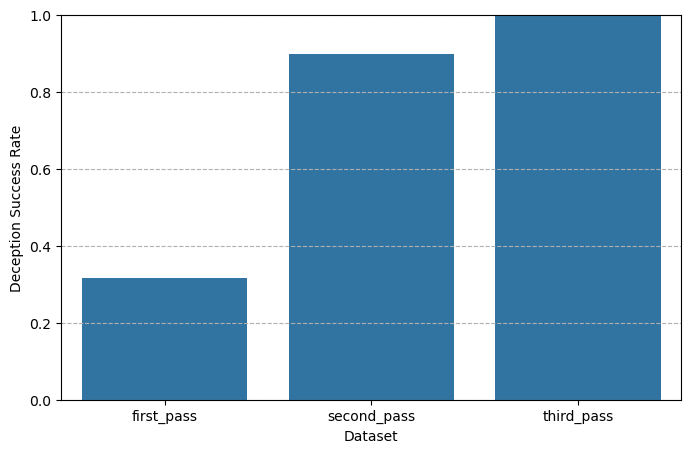

In [23]:
awareness = pd.pivot_table(
    data,
    values='awareness',
    index=['dataset', 'subject'],
    aggfunc=lambda x: ', '.join(x.unique())
).reset_index()

awareness['awareness'] = awareness.apply(
    lambda row: 1 if (row['dataset'] == 'first_pass' and row['awareness'].strip() == 'no') or 
                       (row['dataset'] != 'first_pass' and row['awareness'].strip() == 'yes')
                else 0,
    axis=1
)

# Use Seaborn to create a bar plot showing the average awareness rate per dataset
plt.figure(figsize=(8, 5))
sns.barplot(data=awareness, x='dataset', y='awareness', ci=None)
# plt.title('Deception Success Rates by Dataset')
plt.xlabel('Dataset')
plt.ylabel('Deception Success Rate')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# Output directory for saving plots
output_dir = '/Users/jordangunn/jatos/study_assets_root/online_experiments/experiments/sortablerank/first_pass_figures/'
os.makedirs(output_dir, exist_ok=True)

# Define combinations to loop through
combinations = []

# 1) All orderings and all task types [1 plot per dataset]
combinations.append({'name': 'overall', 'filters': {}})

# Get unique levels for ordering and task_type
ordering_levels = data['ordering'].unique()
task_type_levels = data['task_type'].unique()

# 2) Each ordering, across all task types
if len(ordering_levels) > 1:
    for ordering in ordering_levels:
        combinations.append({
            'name': f'ordering_{ordering}',
            'filters': {'ordering': ordering}
        })
else:
    # Ordering has only one level in first_pass_data
    print(f"Dataset {dataset_name} has only one ordering level.")

# 3) Each task type, across all orderings
for task_type in task_type_levels:
    combinations.append({
        'name': f'task_type_{task_type}',
        'filters': {'task_type': task_type}
    })

# 4) Each task type and each ordering
if len(ordering_levels) > 1:
    for task_type in task_type_levels:
        for ordering in ordering_levels:
            combinations.append({
                'name': f'task_type_{task_type}_ordering_{ordering}',
                'filters': {'task_type': task_type, 'ordering': ordering}
            })
else:
    # Skip since only one ordering level
    print(f"Dataset {dataset_name} does not have multiple ordering levels for task_type and ordering combinations.")

# Loop through combinations and generate plots
for combo in combinations:
    plot_name = f"{dataset_name}_{combo['name']}"
    # Apply filters
    filtered_data = data
    for key, value in combo['filters'].items():
        filtered_data = filtered_data[filtered_data[key] == value]
    
    # Check if filtered_data is not empty
    if filtered_data.empty:
        print(f"No data for {plot_name}, skipping.")
        continue
    
    # Generate the plot
    save_path = os.path.join(output_dir, f"{plot_name}.png")
    plot_title = f"Homophily Check: {dataset_name} - {combo['name']}"
    print(f"Generating plot: {plot_name}")
    plot_homophily_check(filtered_data, save_path=save_path, plot_title=plot_title)

Generating plot: pooled123_overall
Generating plot: pooled123_ordering_0
Generating plot: pooled123_ordering_1


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: pooled123_task_type_full_ranking
Generating plot: pooled123_task_type_choice_ranking
Generating plot: pooled123_task_type_full_ranking_ordering_0


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy

Generating plot: pooled123_task_type_full_ranking_ordering_1
Generating plot: pooled123_task_type_choice_ranking_ordering_0
Generating plot: pooled123_task_type_choice_ranking_ordering_1


/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_counts = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipykernel_5224/1133449835.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expected_proportions = data.groupby('subject').apply(
/var/folders/7n/m1dxq2r12b77t0c09mty9kn00000gn/T/ipy